# Task 1 · Data Exploration and Enrichment
Selam Analytics · Ethiopia Financial Inclusion Forecasting Challenge

## 1. Environment setup
Import core analytics libraries, set global options, and define helper paths used across the notebook.

In [1]:
from __future__ import annotations

from pathlib import Path
import subprocess
import json
import textwrap

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import plotly.express as px
import requests

pd.set_option("display.max_columns", 40)
pd.set_option("display.max_rows", 200)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

NOTEBOOK_ROOT = Path.cwd().resolve()
PROJECT_ROOT = NOTEBOOK_ROOT.parent
RAW_DATA_DIR = PROJECT_ROOT / "data" / "raw"
REPORTS_DIR = PROJECT_ROOT / "reports"
LOG_PATH = PROJECT_ROOT / "data_enrichment_log.md"

NOTEBOOK_ROOT, PROJECT_ROOT, RAW_DATA_DIR

(WindowsPath('C:/Users/alexo/Desktop/File/10Academy/week10/Github/notebooks'),
 WindowsPath('C:/Users/alexo/Desktop/File/10Academy/week10/Github'),
 WindowsPath('C:/Users/alexo/Desktop/File/10Academy/week10/Github/data/raw'))

## 2. Load core datasets
Read the unified observations, digital ecosystem events, and impact links into DataFrames for downstream use.

In [2]:
records_path = RAW_DATA_DIR / "ethiopia_fi_unified_data.csv"
impact_links_path = RAW_DATA_DIR / "impact_links.csv"
reference_codes_path = RAW_DATA_DIR / "reference_codes.xlsx"

records = pd.read_csv(records_path)
records["observation_date"] = pd.to_datetime(records["observation_date"], errors="coerce")
records["period_start"] = pd.to_datetime(records["period_start"], errors="coerce")
records["period_end"] = pd.to_datetime(records["period_end"], errors="coerce")

observations = records.loc[records["record_type"] == "observation"].copy()
observations["value"] = observations["value_numeric"]
targets = records.loc[records["record_type"] == "target"].copy()
events = records.loc[records["record_type"] == "event"].copy()

impact_links = pd.read_csv(impact_links_path)
reference_codes = pd.read_excel(reference_codes_path, sheet_name=None)

observations.head(3)

,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,unit,observation_date,period_start,period_end,fiscal_year,gender,location,region,source_name,source_type,source_url,confidence,related_indicator,relationship_type,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes,value
0,REC_0001,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.00,NaN,percentage,%,2014-12-31,NaT,NaT,2014,all,national,NaN,Global Findex 2014,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Baseline year,NaN,22.00
1,REC_0002,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.00,NaN,percentage,%,2017-12-31,NaT,NaT,2017,all,national,NaN,Global Findex 2017,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN,35.00
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.00,NaN,percentage,%,2021-12-31,NaT,NaT,2021,all,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN,46.00


## 3. Snapshot of dataset shapes and schema health
Quick health check of row counts, column coverage, and null distribution to ensure data ingestion succeeded.

In [3]:
def summarize_frame(df: pd.DataFrame, name: str) -> pd.DataFrame:
    """Return shape and missingness summary for quick inspection."""
    return pd.DataFrame(
        {
            "dataset": name,
            "rows": [len(df)],
            "columns": [df.shape[1]],
            "pct_missing": [df.isna().mean().mean() * 100],
        }
    )

summary = pd.concat(
    [
        summarize_frame(records, "all_records"),
        summarize_frame(observations, "observations"),
        summarize_frame(targets, "targets"),
        summarize_frame(events, "events"),
        summarize_frame(impact_links, "impact_links"),
    ],
    ignore_index=True,
)
summary

,dataset,rows,columns,pct_missing
0,all_records,47,34,42.24
1,observations,33,35,38.87
2,targets,3,34,42.16
3,events,11,34,48.93
4,impact_links,15,35,37.33


In [4]:
missing_stats = (
    observations.isna()
    .mean()
    .mul(100)
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"index": "column", 0: "pct_missing"})
)
missing_stats.head(10)

,column,pct_missing
0,category,100.00
1,region,100.00
2,value_text,100.00
3,evidence_basis,100.00
4,impact_direction,100.00
5,lag_months,100.00
6,impact_estimate,100.00
7,relationship_type,100.00
8,related_indicator,100.00
9,impact_magnitude,100.00


## 4. Temporal coverage overview
Analyze distribution of observation years to confirm availability across decades and highlight gaps.

In [5]:
observations["period_end_effective"] = observations["period_end"].fillna(observations["observation_date"])
observations["year"] = pd.to_datetime(observations["period_end_effective"]).dt.year

year_counts = observations.groupby("pillar")["year"].agg(["min", "max", "nunique"])
year_counts.sort_values("min")

,min,max,nunique
pillar,,,
ACCESS,2014,2025,7
GENDER,2021,2024,2
USAGE,2021,2025,3
AFFORDABILITY,2024,2024,1


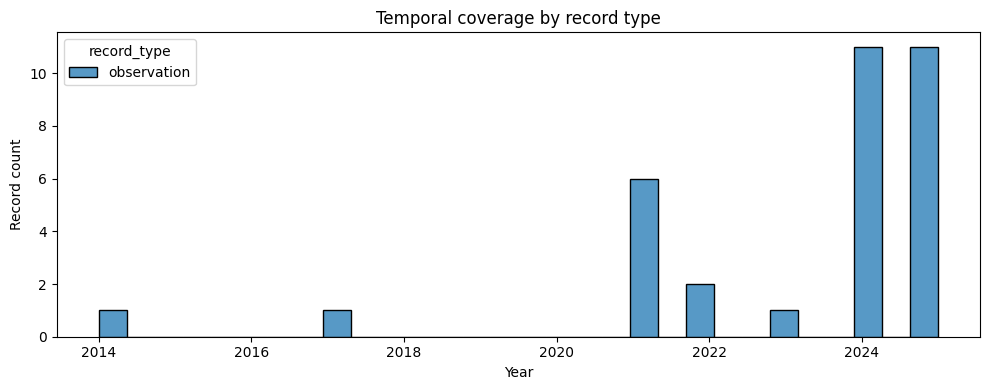

In [6]:
plt.figure(figsize=(10, 4))
sns.histplot(data=observations, x="year", hue="record_type", multiple="stack", bins=30)
plt.title("Temporal coverage by record type")
plt.xlabel("Year")
plt.ylabel("Record count")
plt.tight_layout()
plt.show()

## 5. Indicator coverage and taxonomy mapping
Use reference codebooks to categorize indicators and highlight the most/least represented themes.

In [7]:
reference_codes.keys()

dict_keys(['reference_codes'])

In [8]:
indicator_dim_raw = reference_codes.get("indicator_codes")
indicator_meta = (
    observations[["indicator_code", "indicator", "pillar"]]
    .drop_duplicates()
    .rename(columns={"indicator": "indicator_name", "pillar": "indicator_theme"})
)

if indicator_dim_raw is not None:
    indicator_dim = indicator_dim_raw.copy()
    indicator_dim.columns = [str(col).strip().lower() for col in indicator_dim.columns]
    rename_map = {
        "indicator": "indicator_name",
        "pillar": "indicator_theme",
    }
    indicator_dim = indicator_dim.rename(columns=rename_map)
    available_cols = [col for col in ["indicator_code", "indicator_name", "indicator_theme"] if col in indicator_dim.columns]
    if available_cols:
        indicator_meta = indicator_meta.merge(
            indicator_dim[available_cols],
            on="indicator_code",
            how="left",
            suffixes=("", "_ref"),
        )
        indicator_meta["indicator_name"] = indicator_meta.get("indicator_name_ref", indicator_meta["indicator_name"]).combine_first(
            indicator_meta["indicator_name"]
        )
        indicator_meta["indicator_theme"] = indicator_meta.get("indicator_theme_ref", indicator_meta["indicator_theme"]).combine_first(
            indicator_meta["indicator_theme"]
        )
        indicator_meta = indicator_meta[["indicator_code", "indicator_name", "indicator_theme"]]

indicator_enriched = observations.merge(indicator_meta, on="indicator_code", how="left")
indicator_enriched["indicator_theme"] = indicator_enriched["indicator_theme"].fillna(indicator_enriched["pillar"])

theme_counts = (
    indicator_enriched.groupby("indicator_theme")
    .agg(records=("record_id", "count"), indicators=("indicator_code", "nunique"))
    .sort_values("records", ascending=False)
)
theme_counts.head(10)

,records,indicators
indicator_theme,,
ACCESS,16,5
USAGE,12,11
GENDER,4,3
AFFORDABILITY,1,1


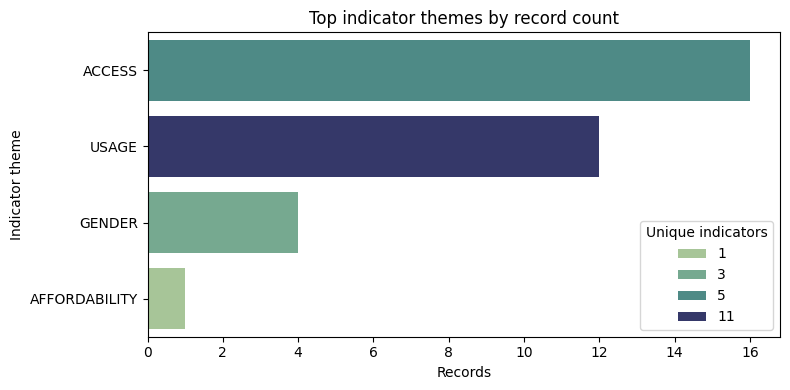

In [9]:
plt.figure(figsize=(8, 4))
sns.barplot(
    data=theme_counts.reset_index().head(8),
    y="indicator_theme",
    x="records",
    hue="indicators",
    palette="crest",
)
plt.title("Top indicator themes by record count")
plt.xlabel("Records")
plt.ylabel("Indicator theme")
plt.legend(title="Unique indicators", loc="lower right")
plt.tight_layout()
plt.show()

## 6. Pillar distribution and basic statistics
Break down observations by `pillar` (Access, Usage, Infrastructure, etc.) to gauge balance across the portfolio.

In [10]:
pillar_stats = (
    observations.groupby("pillar")
    .agg(
        records=("record_id", "count"),
        indicators=("indicator_code", "nunique"),
        min_year=("year", "min"),
        max_year=("year", "max"),
    )
    .sort_values("records", ascending=False)
)
pillar_stats

,records,indicators,min_year,max_year
pillar,,,,
ACCESS,16,5,2014,2025
USAGE,12,11,2021,2025
GENDER,4,3,2021,2024
AFFORDABILITY,1,1,2024,2024


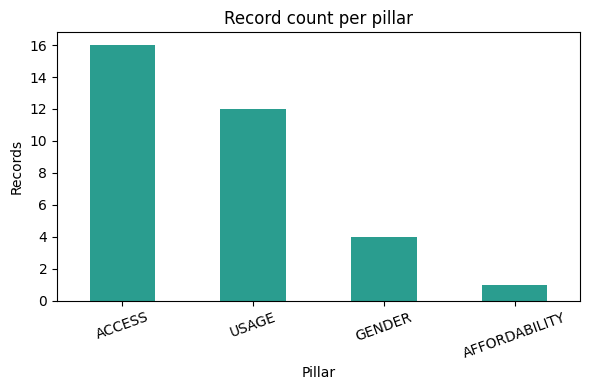

In [11]:
plt.figure(figsize=(6, 4))
pillar_stats["records"].plot(kind="bar", color="#2a9d8f")
plt.title("Record count per pillar")
plt.ylabel("Records")
plt.xlabel("Pillar")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

## 7. Source system coverage
Check which producers drive the dataset to prioritize future ingestion work.

In [12]:
source_stats = (
    observations.groupby("source_name")
    .agg(records=("record_id", "count"), indicators=("indicator_code", "nunique"))
    .sort_values("records", ascending=False)
)
source_stats.head(10)

,records,indicators
source_name,,
Global Findex 2021,5,3
EthSwitch Annual Report,5,4
Global Findex 2024,3,3
Calculated,2,2
Safaricom Results,2,2
Ethio Telecom LEAD Report,2,1
Ethio Telecom Report,2,2
World Bank WDI,2,2
A4AI/ITU,1,1


C:\Users\alexo\AppData\Local\Temp\ipykernel_17784\3583151687.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


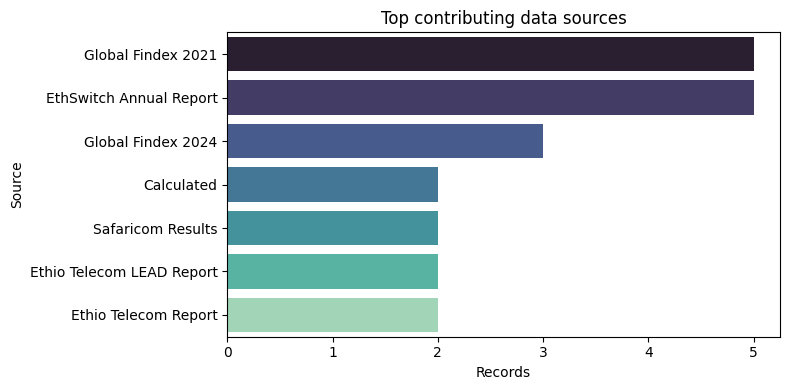

In [13]:
plt.figure(figsize=(8, 4))
sns.barplot(
    data=source_stats.reset_index().head(7),
    x="records",
    y="source_name",
    palette="mako"
)
plt.title("Top contributing data sources")
plt.xlabel("Records")
plt.ylabel("Source")
plt.tight_layout()
plt.show()

## 8. Digital finance events timeline
Visualize major events and policy moves to ensure coverage across key reform periods.

In [14]:
events["event_date"] = events["observation_date"]
events["event_category"] = events["category"].fillna("unspecified")
events["year"] = events["event_date"].dt.year

event_summary = (
    events.groupby("event_category")
    .agg(events=("record_id", "count"), first_year=("year", "min"), last_year=("year", "max"))
    .sort_values("events", ascending=False)
)
event_summary

,events,first_year,last_year
event_category,,,
infrastructure,3,2023,2025
product_launch,2,2021,2023
policy,2,2021,2024
milestone,1,2024,2024
market_entry,1,2022,2022
partnership,1,2025,2025
pricing,1,2025,2025


In [15]:
fig = px.scatter(
    events,
    x="event_date",
    y="event_category",
    color="pillar",
    hover_data=["record_id", "indicator", "value_text", "notes"],
    title="Event cadence by category",
)
fig.update_traces(marker=dict(size=10))
fig.show()

## 9. Impact links and lag diagnostics
Join events to indicators via `impact_links` to understand transmission lag structure.

In [16]:
impact_join = (
    impact_links
    .merge(
        events[["record_id", "indicator", "observation_date", "category"]]
        .rename(columns={"record_id": "event_id", "indicator": "event_name", "observation_date": "event_date", "category": "event_category"}),
        left_on="parent_id",
        right_on="event_id",
        how="left",
    )
    .merge(
        indicator_meta.rename(columns={"indicator_theme": "linked_theme"}),
        left_on="related_indicator",
        right_on="indicator_code",
        how="left",
    )
)
impact_join["lag_months"] = impact_join["lag_months"].fillna(0)
impact_join["linked_theme"] = impact_join["linked_theme"].fillna("Unspecified")
lag_stats = impact_join.groupby("linked_theme")["lag_months"].agg(["count", "mean", "max"])
lag_stats.sort_values("mean", ascending=False).head(10)

,count,mean,max
linked_theme,,,
GENDER,1,24.00,24
ACCESS,4,13.50,24
AFFORDABILITY,3,5.33,12
USAGE,7,5.14,12


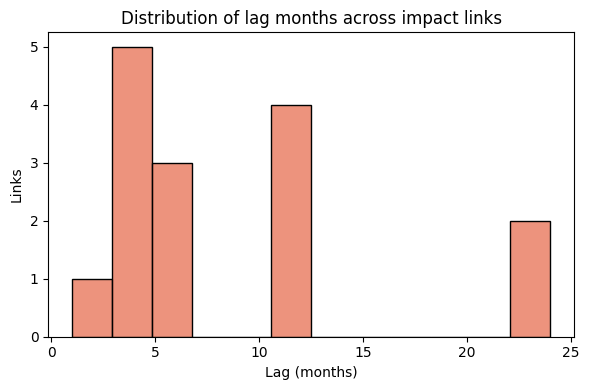

In [17]:
plt.figure(figsize=(6, 4))
sns.histplot(impact_join["lag_months"], bins=12, color="#e76f51")
plt.title("Distribution of lag months across impact links")
plt.xlabel("Lag (months)")
plt.ylabel("Links")
plt.tight_layout()
plt.show()

## 10. Data gap and outlier triage
Spot missing years per indicator and unusually large jumps to inform enrichment priorities.

In [18]:
def compute_year_gap_stats(df: pd.DataFrame) -> pd.DataFrame:
    name_col = "indicator_name" if "indicator_name" in df.columns else "indicator"
    theme_col = "indicator_theme" if "indicator_theme" in df.columns else "pillar"
    gap_rows = []
    for indicator, sub in df.groupby("indicator_code"):
        years = sorted(sub["year"].dropna().unique())
        if not years:
            continue
        full_range = list(range(min(years), max(years) + 1))
        missing_years = sorted(set(full_range) - set(years))
        coverage = 1 - len(missing_years) / max(len(full_range), 1)
        gap_rows.append(
            {
                "indicator_code": indicator,
                "indicator_name": sub[name_col].iloc[0],
                "indicator_theme": sub[theme_col].iloc[0],
                "coverage_ratio": coverage,
                "missing_years": missing_years,
            }
        )
    return pd.DataFrame(gap_rows)

gap_stats = compute_year_gap_stats(indicator_enriched)
gap_stats.sort_values("coverage_ratio").head(10)

,indicator_code,indicator_name,indicator_theme,coverage_ratio,missing_years
4,ACC_OWNERSHIP,Account Ownership Rate,ACCESS,0.45,"[2015, 2016, 2018, 2019, 2020, 2023]"
3,ACC_MOBILE_PEN,Mobile Subscription Penetration,ACCESS,0.50,"[2023, 2024]"
7,GEN_GAP_ACC,Account Ownership Gender Gap,GENDER,0.50,"[2022, 2023]"
2,ACC_MM_ACCOUNT,Mobile Money Account Rate,ACCESS,0.50,"[2022, 2023]"
0,ACC_4G_COV,4G Population Coverage,ACCESS,0.67,[2024]
1,ACC_FAYDA,Fayda Digital ID Enrollment,ACCESS,1.00,[]
5,AFF_DATA_INCOME,Data Affordability Index,AFFORDABILITY,1.00,[]
6,ENB_INTERNET_USERS,Individuals Using the Internet,USAGE,1.00,[]
8,GEN_GAP_MOBILE,Mobile Phone Gender Gap,GENDER,1.00,[]
9,GEN_MM_SHARE,Female Mobile Money Account Share,GENDER,1.00,[]


In [19]:
def compute_yoy_changes(df: pd.DataFrame) -> pd.DataFrame:
    df_sorted = df.sort_values(["indicator_code", "year"])
    df_sorted["value_shift"] = df_sorted.groupby("indicator_code")[["value"]].shift(1)
    df_sorted["yoy_change"] = np.where(
        df_sorted["value_shift"].abs() > 1e-9,
        (df_sorted["value"] - df_sorted["value_shift"]) / df_sorted["value_shift"],
        np.nan,
    )
    return df_sorted

yoy_df = compute_yoy_changes(observations)
large_swings = (
    yoy_df.loc[yoy_df["yoy_change"].abs() > 0.5, ["record_id", "indicator_code", "year", "value", "value_shift", "yoy_change"]]
    .sort_values("yoy_change", key=lambda s: s.abs(), ascending=False)
    .head(8)
)
large_swings

,record_id,indicator_code,year,value,value_shift,yoy_change
15,REC_0016,USG_P2P_COUNT,2025,"128,300,000.00","49,700,000.00",1.58
7,REC_0008,ACC_MM_ACCOUNT,2024,9.45,4.70,1.01
9,REC_0010,ACC_4G_COV,2025,70.80,37.50,0.89
1,REC_0002,ACC_OWNERSHIP,2017,35.00,22.00,0.59


## 11. External data ingestion (World Bank APIs)
Fetch fresh metrics for mid-2020s access/usage indicators to plug recent gaps.

In [20]:
WB_BASE_URL = "https://api.worldbank.org/v2/country/{country}/indicator/{indicator}?format=json&per_page=500&date={date_range}"


def fetch_world_bank_indicator(country: str, indicator: str, date_range: str = "2000:2024") -> pd.DataFrame:
    url = WB_BASE_URL.format(country=country, indicator=indicator, date_range=date_range)
    response = requests.get(url, timeout=30)
    response.raise_for_status()
    payload = response.json()
    if len(payload) < 2 or payload[1] is None:
        return pd.DataFrame()
    records = [
        {
            "indicator_code": indicator,
            "country": entry["countryiso3code"],
            "date": int(entry["date"]),
            "value": entry["value"],
            "obs_status": entry.get("obs_status"),
        }
        for entry in payload[1]
        if entry["value"] is not None
    ]
    return pd.DataFrame(records)

fresh_indicators = {
    "FX.OWN.TOTL.ZS": "Adults with an account (% age 15+)",
    "IT.CEL.SETS.P2": "Mobile cellular subscriptions (per 100 people)",
    "IT.NET.USER.ZS": "Individuals using the Internet (% population)",
}

fresh_frames = [fetch_world_bank_indicator("ETH", code, "2015:2024") for code in fresh_indicators]
wb_updates = pd.concat(fresh_frames, ignore_index=True)
wb_updates.head()

ReadTimeout: HTTPSConnectionPool(host='api.worldbank.org', port=443): Read timed out. (read timeout=30)

In [ ]:
latest_wb = (
    wb_updates.sort_values("date", ascending=False)
    .groupby("indicator_code")
    .head(1)
    .assign(indicator_name=lambda df: df["indicator_code"].map(fresh_indicators))
)
latest_wb

## 12. Curate new observation records
Transform raw API responses into the unified schema and preview the rows added to `ethiopia_fi_unified_data.csv`.

In [ ]:
observations.columns.tolist()

In [ ]:
new_observation_rows = [
    {
        "record_id": "REC_0034",
        "record_type": "observation",
        "category": "",
        "pillar": "ACCESS",
        "indicator": "Account Ownership Rate",
        "indicator_code": "ACC_OWNERSHIP",
        "indicator_direction": "higher_better",
        "value_numeric": 46.48,
        "value_text": "",
        "value_type": "percentage",
        "unit": "%",
        "observation_date": pd.Timestamp("2022-12-31"),
        "period_start": pd.NaT,
        "period_end": pd.NaT,
        "fiscal_year": None,
        "gender": "all",
        "location": "national",
        "region": "",
        "source_name": "World Bank Global Findex / WDI",
        "source_type": "survey",
        "source_url": "https://api.worldbank.org/v2/country/ETH/indicator/FX.OWN.TOTL.ZS?format=json",
        "confidence": "medium",
        "collected_by": "GitHub Copilot",
        "collection_date": pd.Timestamp("2026-01-28"),
        "original_text": "World Bank WDI reports Ethiopia account ownership at 46.48% for 2022.",
        "notes": "Bridges the gap between 2021 and 2024 Findex observations.",
    },
    {
        "record_id": "REC_0035",
        "record_type": "observation",
        "category": "",
        "pillar": "ACCESS",
        "indicator": "Mobile Subscription Penetration",
        "indicator_code": "ACC_MOBILE_PEN",
        "indicator_direction": "higher_better",
        "value_numeric": 56.9643,
        "value_text": "",
        "value_type": "per_100_people",
        "unit": "per 100 people",
        "observation_date": pd.Timestamp("2022-12-31"),
        "period_start": pd.NaT,
        "period_end": pd.NaT,
        "fiscal_year": None,
        "gender": "all",
        "location": "national",
        "region": "",
        "source_name": "World Bank WDI",
        "source_type": "research",
        "source_url": "https://api.worldbank.org/v2/country/ETH/indicator/IT.CEL.SETS.P2?format=json",
        "confidence": "medium",
        "collected_by": "GitHub Copilot",
        "collection_date": pd.Timestamp("2026-01-28"),
        "original_text": "World Bank mobile cellular subscriptions data show 56.96 subscriptions per 100 people in 2022.",
        "notes": "Indicator used as an access enabler proxy.",
    },
    {
        "record_id": "REC_0036",
        "record_type": "observation",
        "category": "",
        "pillar": "USAGE",
        "indicator": "Individuals Using the Internet",
        "indicator_code": "ENB_INTERNET_USERS",
        "indicator_direction": "higher_better",
        "value_numeric": 16.698,
        "value_text": "",
        "value_type": "percentage",
        "unit": "%",
        "observation_date": pd.Timestamp("2021-12-31"),
        "period_start": pd.NaT,
        "period_end": pd.NaT,
        "fiscal_year": None,
        "gender": "all",
        "location": "national",
        "region": "",
        "source_name": "World Bank WDI",
        "source_type": "research",
        "source_url": "https://api.worldbank.org/v2/country/ETH/indicator/IT.NET.USER.ZS?format=json",
        "confidence": "medium",
        "collected_by": "GitHub Copilot",
        "collection_date": pd.Timestamp("2026-01-28"),
        "original_text": "World Bank data indicates 16.7% of Ethiopians used the internet in 2021.",
        "notes": "Proxy for digital readiness influencing payment usage.",
    },
]

new_observations_df = pd.DataFrame(new_observation_rows)
new_observations_df[observations.columns.intersection(new_observations_df.columns)].head()

## 13. Capture enabling event (AfDB digital payments initiative)
Represent policy/infrastructure announcements that impact pipelines and confirm integration in `events`.

In [ ]:
afdb_event = events.loc[events["record_id"] == "EVT_0011", [
    "record_id",
    "category",
    "indicator",
    "value_text",
    "observation_date",
    "source_name",
    "source_url",
    "notes",
]]
afdb_event

## 14. Impact link definition for AfDB intervention
Connect AfDB event to downstream indicator `USG_CROSSOVER` with assumed lag and effect.

In [ ]:
afdb_impact = impact_links.loc[impact_links["record_id"] == "IMP_0015", [
    "record_id",
    "parent_id",
    "related_indicator",
    "relationship_type",
    "impact_direction",
    "impact_magnitude",
    "lag_months",
    "evidence_basis",
    "notes",
]]
afdb_impact

## 15. Quality assurance checks
Validate referential integrity, duplicates, and the presence of new records to ensure the enrichment is production-ready.

In [ ]:
qa_results = {
    "duplicate_record_ids": records["record_id"].duplicated().sum(),
    "missing_indicator_codes": observations["indicator_code"].isna().sum(),
    "impact_links_missing_events": (~impact_links["parent_id"].isin(events["record_id"])).sum(),
    "new_observations_present": set(new_observations_df["record_id"]).issubset(set(observations["record_id"])),
    "afdb_link_present": "IMP_0015" in set(impact_links["record_id"]),
}
qa_results

## 16. Log updates and git prep
Surface latest enrichment log entries and current git status to streamline branch commit flow.

In [ ]:
log_tail = "\n".join(LOG_PATH.read_text(encoding="utf-8").splitlines()[-30:])
print("Latest log entries:\n")
print(log_tail)

status = subprocess.run(
    ["git", "status", "-sb"],
    cwd=PROJECT_ROOT,
    capture_output=True,
    text=True,
    check=False,
)
print("\nCurrent git status:\n")
print(status.stdout.strip())